# Exploring Geo-Data

## Loading Data

In this section we download the data from a remote server and save it to a working directory on our computer.

### Setup

In [1]:
from pathlib import Path

src_dir = Path.home() / Path('work/data/clean')

if not src_dir.exists():
    src_dir.mkdir(parents=True)
    print(f"Creating a 'clean' directory for data in {src_dir}.")

Below we are setting up some basic *variables* that we'll use to manage the download porcess. The data is all accessible from a CASA server called 'Orca' (`base_url`) and then we have a list of the data and geodata that we will need to download. Note that, when approaching a problem with code, we can be 'lazy' and not even specify the file extension (`.parquet`) because we can *add* then when downloading each file.

In [2]:
base_url = 'https://orca.casa.ucl.ac.uk/~jreades/jaipur'

geofiles = [
    'Jaipur_Boundary', 'Jaipur_Wards', 'northern-zone-lines', 'northern-zone-multilines', 'northern-zone-multipolygons', 
    'northern-zone-other', 'northern-zone-points', 'India_Country_Boundary', 'India_State_Boundary'
]

print(f"The geo-data files are: {', '.join(geofiles)}")

The geo-data files are: Jaipur_Boundary, Jaipur_Wards, northern-zone-lines, northern-zone-multilines, northern-zone-multipolygons, northern-zone-other, northern-zone-points, India_Country_Boundary, India_State_Boundary


### Download

Notice the `exists()` part -- we are checking for the existence of a file locally *before* we try to download it!

In [3]:
# urlretrieve is a function (provided by Python) for 
# downloading a file from a URL and saving it locally
from urllib.request import urlretrieve

# For each geo-data file
for f in geofiles:
    print(f"Retrieving {f} table.")
    save_path = Path(src_dir / f"{f}.geoparquet")
    if save_path.exists():
        print("\tAlready downloaded this data...")
    else: 
        print("\tDownloading...")
        urlretrieve(f"{base_url}/{f}.geoparquet", save_path)

Retrieving Jaipur_Boundary table.
	Already downloaded this data...
Retrieving Jaipur_Wards table.
	Already downloaded this data...
Retrieving northern-zone-lines table.
	Already downloaded this data...
Retrieving northern-zone-multilines table.
	Already downloaded this data...
Retrieving northern-zone-multipolygons table.
	Already downloaded this data...
Retrieving northern-zone-other table.
	Already downloaded this data...
Retrieving northern-zone-points table.
	Already downloaded this data...
Retrieving India_Country_Boundary table.
	Downloading...
Retrieving India_State_Boundary table.
	Downloading...


## Geo-Data

All *geo*-data needs to be read in using *geo*-pandas, which we import using an 'alias' (`gpd`) to save time.

In [4]:
import geopandas as gpd # We only need to do this *once*

## A Base Map

This next group of commands isn't very friendly to the orca server (especially if you *keep* running this code!), but it is useful for demonstrating that you can even read a file on another server when it's in the parquet format. We literally just 'request' the file and geopandas can load it dynamically. 

<Axes: >

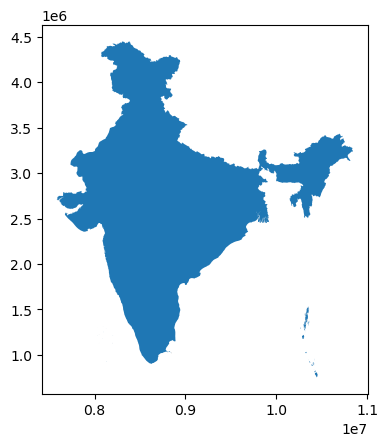

In [7]:
import requests, io
result = requests.get(f"{base_url}/India_Country_Boundary.geoparquet")
india = gpd.read_parquet(io.BytesIO(result.content))
india.plot()

<Axes: >

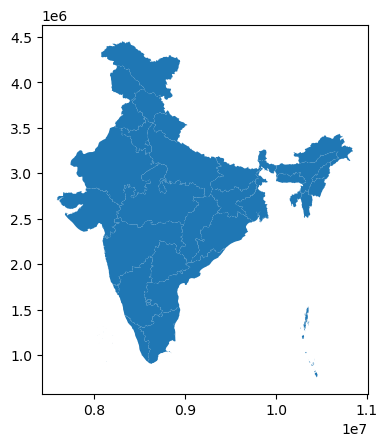

In [9]:
istates = gpd.read_parquet(src_dir / 'India_State_Boundary.geoparquet')
istates.plot()

In [10]:
istates.head()

,State_Name,geometry
0,Andaman & Nicobar,"MULTIPOLYGON (((10341718.474 1449533.161, 1034..."
1,Chandigarh,"POLYGON ((8546255.616 3606050.813, 8546315.4 3..."
2,Daman and Diu and Dadra and Nagar Haveli,"MULTIPOLYGON (((8122247.822 2312434.407, 81223..."
3,Delhi,"POLYGON ((8583390.57 3359116.19, 8583476.212 3..."
4,Haryana,"POLYGON ((8524318.539 3516490.865, 8524451.392..."


<Axes: >

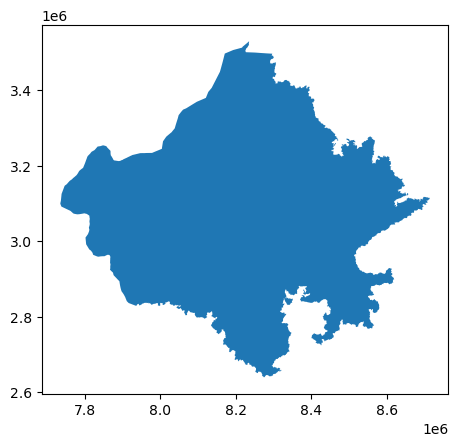

In [12]:
raja = istates[istates.State_Name=='Rajasthan']
raja.plot()

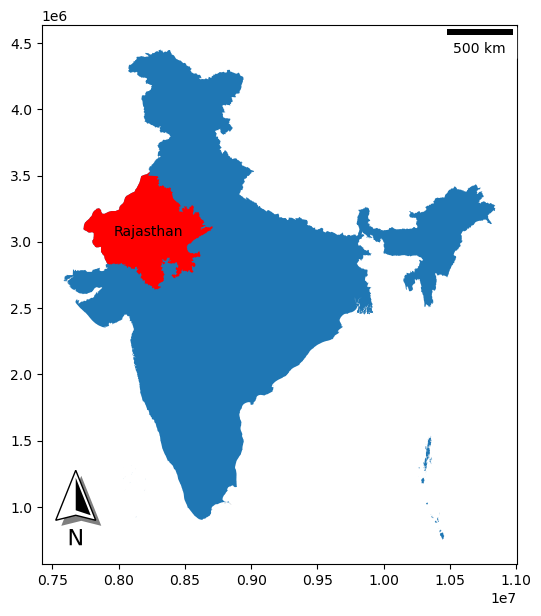

In [27]:
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils.core.north_arrow import NorthArrow, north_arrow

f, ax = plt.subplots(1,1,figsize=(7,7))
india.plot(ax=ax)
raja.plot(color='red', ax=ax)
plt.text(raja.centroid.x.iloc[0], raja.centroid.y.iloc[0], 'Rajasthan', horizontalalignment='center', verticalalignment='center')
scalebar = ScaleBar(1)
ax.add_artist(scalebar)
north_arrow(
    ax, location="lower left", rotation={"crs": india.crs, "reference": "center"}
)

## Exploring Jaipur

Let's start by exploring the boundary file for Jaipur, which we downloaded from Orca and are now going to read in.

In [50]:
jp = gpd.read_parquet(src_dir / 'Jaipur_Boundary.geoparquet')
# What does it contain?
print(f"`jp` has shape: {jp.shape}")

`jp` has shape: (1, 2)


That `shape` output isn't very intelligible; fortunately, we with a small file we can also *show* what it contains quite easily.

In [51]:
jp

,Id,geometry
0,0,"LINESTRING (573800.054 2987272.258, 572822.461..."


In [92]:
jp.Id # `loc[<index identifier>]` is how we access an individual row

0    0
Name: Id, dtype: int32

In [91]:
jp.geometry

0    LINESTRING (573800.054 2987272.258, 572822.461...
Name: geometry, dtype: geometry

Notice the `0` on the left: that's the same `0` shown in bold when we just run `jp`. This is an **index**, which is a kind of row identifier. Technically, indexes can be labels or numbers, but here we just have the row number.

So, that's all well and good, but what does it look like? Let's find out!

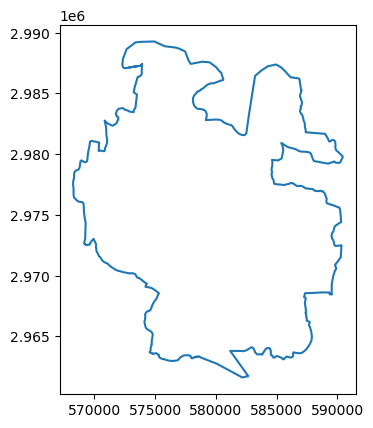

In [54]:
jp.plot();

<Axes: >

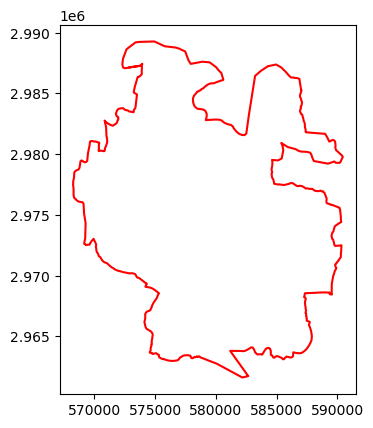

In [22]:
jp.plot(color='red');

<Axes: >

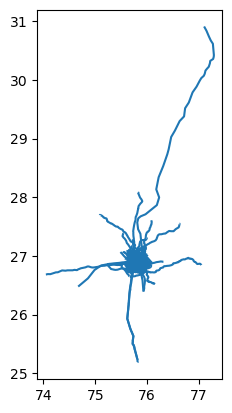

In [23]:
osml = gpd.read_parquet(src_dir / 'northern-zone-lines.geoparquet')
osml.plot();

To show these together we need to combine them into one plot. The way we do this in Python is as follows:

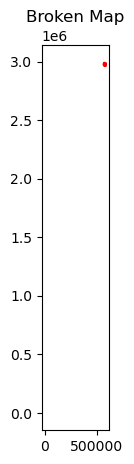

In [46]:
import matplotlib.pyplot as plt

f, axis = plt.subplots(1,1,figsize=(7,5))
axis.set_title("Broken Map")
jp.plot(color='red', ax=axis)
osml.plot(color='orange', ax=axis);

<div class="alert alert-block alert-warning">

### &#9888; Warning

That 'map' doesn't look right, does it? Can the *planners* tell us why? Below is a hint...

</div>

In [90]:
print(f"The Jaipur CRS (map projection) is: {jp.crs.name}")
print()
print(f"The OSM Lines CRS (map projection) is: {osml.crs.name}")

The Jaipur CRS (map projection) is WGS 84 / UTM zone 43N

The OSM Lines CRS (map projection) is WGS 84


### A Quick Map

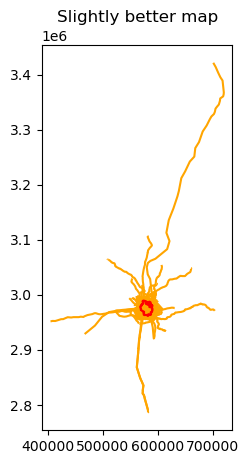

In [48]:
f, axis = plt.subplots(1,1,figsize=(7,5))
axis.set_title("Slightly better map")
osml.to_crs(jp.crs).plot(color='orange', ax=axis)
jp.plot(color='red', ax=axis);

We can use the bounding box for Jaipur to set up the x and y 'limits' of the map.

In [39]:
print(jp.bounds)

            minx          miny           maxx          maxy
0  568250.135611  2.961612e+06  590450.900025  2.989266e+06


(2961611.976768201, 2989266.2252198784)

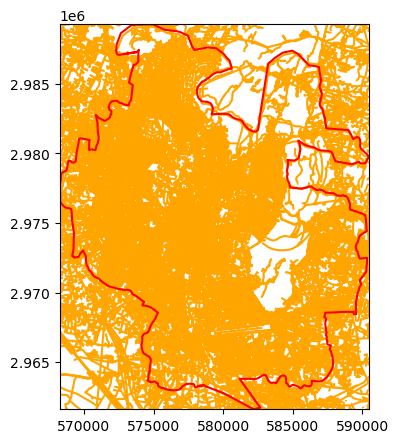

In [40]:
f, axis = plt.subplots(1,1,figsize=(7,5))
osml.to_crs(jp.crs).plot(color='orange', ax=axis)
jp.plot(color='red', ax=axis)
axis.set_xlim([jp.bounds.minx[0], jp.bounds.maxx[0]])
axis.set_ylim([jp.bounds.miny[0], jp.bounds.maxy[0]])

### Buffering a Boundary

But it feels quite awkward cropping the map to *exactly* the edges of the city. Python makes it easy to buffer the border and use *that* instead.

In [55]:
jpb = jp.buffer(5000)
print(jpb.bounds)

            minx          miny           maxx          maxy
0  563254.193248  2.956613e+06  595449.959905  2.994264e+06


(2956613.339466996, 2994264.2321371683)

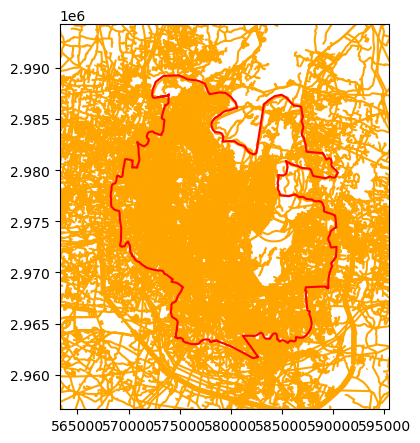

In [56]:
f, axis = plt.subplots(1,1,figsize=(7,5))
osml.to_crs(jp.crs).plot(color='orange', ax=axis)
jp.plot(color='red', ax=axis)

# And now set the limits of the map using the buffer
axis.set_xlim([jpb.bounds.minx[0], jpb.bounds.maxx[0]])
axis.set_ylim([jpb.bounds.miny[0], jpb.bounds.maxy[0]])

## Exploring OSM Data
What *are* all those orange lines? They make it almost impossible to read the map!

Using `head` we can look at the first few records from the data.

In [49]:
osml.head()

,osm_id,name,highway,waterway,aerialway,barrier,man_made,railway,z_order,other_tags,geometry
0,22835306,None,trunk,None,None,None,None,None,8,"""lanes""=>""4"",""oneway""=>""yes"",""ref""=>""NH52"",""re...","LINESTRING (75.79715 26.81889, 75.79755 26.818..."
1,28717241,Mirza Ismail Road,trunk,None,None,None,None,None,8,"""name:etymology:wikidata""=>""Q6874880"",""oneway""...","LINESTRING (75.80143 26.91779, 75.80166 26.917..."
2,28717352,Mirza Ismail Road,primary,None,None,None,None,None,7,"""name:etymology:wikidata""=>""Q6874880"",""oneway""...","LINESTRING (75.79987 26.91832, 75.80004 26.918..."
3,28717397,Agra Jaipur Bikaner Road,trunk,None,None,None,None,None,8,"""oneway""=>""yes"",""ref:old""=>""NH11""","LINESTRING (75.84544 26.90317, 75.84554 26.903..."
4,28776554,None,trunk,None,None,None,None,None,8,"""lanes""=>""2"",""oneway""=>""yes"",""ref""=>""NH248"",""r...","LINESTRING (75.89748 27.04296, 75.89751 27.042..."


In [63]:
osml.highway.unique()

array(['trunk', 'primary', 'secondary', 'tertiary', 'residential',
       'primary_link', 'service', 'living_street', None, 'construction',
       'tertiary_link', 'path', 'footway', 'pedestrian', 'unclassified',
       'steps', 'trunk_link', 'secondary_link', 'track', 'road',
       'cycleway', 'corridor', 'motorway', 'motorway_link'], dtype=object)

In [64]:
highways  = osml[osml.highway.isin(['trunk','primary','secondary'])].to_crs(jp.crs)
waterways = osml[~osml.waterway.isna()].to_crs(jp.crs)

In [65]:
print(f"Highways has shape {highways.shape}")
print(f"Waterways has shape {waterways.shape}")

Highways has shape (1571, 11)
Waterways has shape (190, 11)


## Pulling it All Together

Here is what we want to achieve... 

(2956613.339466996, 2994264.2321371683)

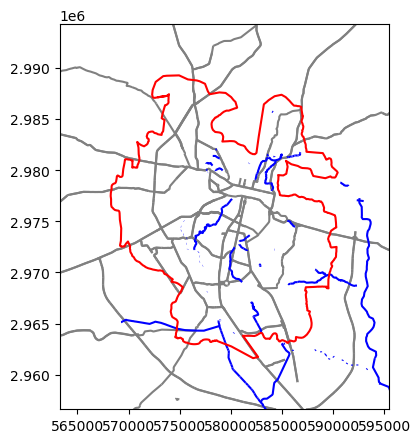

In [66]:
f, axis = plt.subplots(1,1,figsize=(7,5))
highways.plot(color="grey", ax=axis)
waterways.plot(color="blue", ax=axis)
jp.plot(color='red', ax=axis)
axis.set_xlim([jpb.bounds.minx[0], jpb.bounds.maxx[0]])
axis.set_ylim([jpb.bounds.miny[0], jpb.bounds.maxy[0]])

Read more about [colourmaps](https://matplotlib.org/stable/users/explain/colors/colormaps.html) in the documentation.

And here is how to specify a colour [using hexadecimal](https://www.google.com/search?q=hex+color+picker).

(2956613.339466996, 2994264.2321371683)

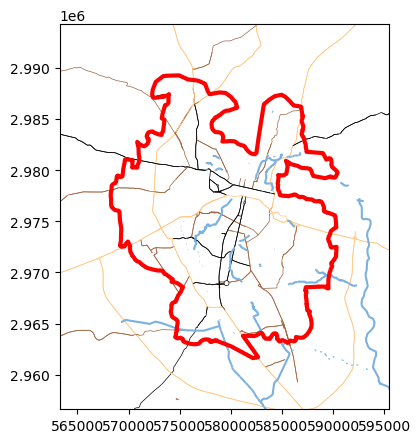

In [79]:
f, axis = plt.subplots(1,1,figsize=(7,5))
highways.plot(column='highway', cmap='copper', linewidth=0.5, ax=axis)
waterways.plot(color="#7bb1e0", ax=axis)
jp.plot(color='red', linewidth=3, ax=axis)
axis.set_xlim([jpb.bounds.minx[0], jpb.bounds.maxx[0]])
axis.set_ylim([jpb.bounds.miny[0], jpb.bounds.maxy[0]]);

### Open Data?

I wanted to also demonstrate how to add raster data but the 'open' India Geo-Platform of ISRO [requires a government-issue login](https://bhuvan-app3.nrsc.gov.in/data/download/index.php). Note the different definition of 'open' here!